### Portfolio Optimization - Wasserstein Ball and Reinforcement Learning

* [1. Import Packages](#1)
* [2. Stock Simulation Function](#2)  
* [3. ANN for mapping State to action](#3)      
* [4. Function toretun portfolio value and Risk Measure](#4)    
* [5. Training](#5)

<a id='1'></a>
### 1. Import Packages

In [ ]:
#!/usr/bin/env python
# coding: utf-8
import numpy as np
import numpy.matlib
from scipy.stats import norm

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy import stats
import seaborn as sns

<a id='2'></a>
### 2. Stock Simulation Function

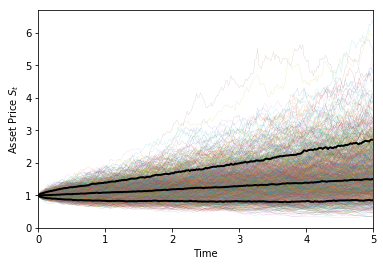

In [2]:
# %%
def SimPath(Ndt, S0, mu, sigma, T, Nsims):
    
    dt = T/Ndt
    
    S = np.zeros((Nsims,Ndt+1))
    S[:,0] = S0
    
    for i in range(Ndt):
        
        dW = np.sqrt(dt) * np.random.randn(Nsims)
        S[:,i+1] = S[:,i] * np.exp((mu-0.5*sigma**2)*dt + sigma*dW)
        
    t = np.linspace(0,T,Ndt+1)
    return t, S
        


# %%
t, S = SimPath(252,1, 0.1, 0.2, 5, 1000)

# %%
Ndt=20

S0=1

T=5

Nsims=500


plt.plot(t, S.T,linewidth=0.1)
plt.plot(t,np.quantile(S,[0.1, 0.5, 0.9],axis=0).T,color='k',linewidth=2)
plt.xlabel("Time")
plt.ylabel("Asset Price $S_t$")
plt.xlim([0,5])
plt.show()

<a id='3'></a>
### 3. ANN for mapping state and weights
In this function we pass the prices of the instruments and get the weights across time

In [3]:
# %%
class MyNet(nn.Module):
    
    def __init__(self, n ):
        super(MyNet, self).__init__()
        
        # 3 input layer (t,S), 1 output channel, 3 hidden layers with n units each
        self.f_in_to_h1 = nn.Linear( 4 , n)
        self.f_h1_to_h2 = nn.Linear(n, n)
        self.f_h2_to_out = nn.Linear(n, 3)
        self.myReLU = nn.ReLU()

    def forward(self, x):
        
        # input into 1st hidden layer
        h1 = self.myReLU(self.f_in_to_h1(x) )
        
        # 1st hidden to 2nd hidden layer
        h2 = self.myReLU(self.f_h1_to_h2(h1))
            
        # 2nd hidden layer to output layer
        y = self.f_h2_to_out(h2)
        
        return y

In [4]:
t, S1 = SimPath(Ndt, 1, .05, .1, T, Nsims)
t, S2 = SimPath(Ndt, 1, .06, .12, T, Nsims)

t

x=np.zeros((Nsims,Ndt+1,3))
x.shape 

x[:,:,0] = np.matlib.repmat(t,Nsims, 1)

x[:,:,1] = S1

x[:,:,2] = S2

xt = torch.tensor(x, dtype=torch.float)

xt[:,:-1,:].shape

torch.Size([500, 20, 3])

In [5]:
#Compute wt
wt = net(xt[:,:-1,:])
#wt

NameError: name 'net' is not defined

In [ ]:
wt[:,:,1].shape

wt 

S1[:,:-1].shape

Val1= wt[:,:,0] * torch.tensor(S1[:,:-1], dtype=torch.float)
Val2= wt[:,:,1] * torch.tensor(S2[:,:-1], dtype=torch.float)
TotalVal = Val1 + Val2

TotalVal.shape

#Weights at time t 
#TotalVal[:, -1]

In [ ]:
wt.shape

In [ ]:
#output for one scenario
wt[0,:,:]

In [ ]:
#Weight at T for all scenarios 
wt[:,-1,:].shape

In [ ]:
Delta_t = torch.tensor(np.zeros((Nsims,Ndt,2)), dtype=torch.float)
Delta_t[:,:,0] = .75
Delta_t[:,:,1] = .25

Val1_index= Delta_t[:,:,0] * torch.tensor(S1[:,:-1], dtype=torch.float, requires_grad=True)
Val2_index= Delta_t[:,:,1] * torch.tensor(S2[:,:-1], dtype=torch.float, requires_grad=True)
TotalVal_index = Val1_index + Val2_index
#TotalVal_index[:, -1]
Delta_t[:,-1,:].shape
#np.array(TotalVal_index.detach())[3]

In [ ]:
#np.array(TotalVal.detach()).mean(axis =0)

In [ ]:
#plt.plot(np.array(TotalVal_index[:1].detach())[0])
#Visual plot to check if the error is reducing
plt.plot(np.array(TotalVal_index.detach())[2], label='Index')
plt.plot(np.array(TotalVal.detach())[2], label='Portfolio')
plt.legend()
plt.show()

In [ ]:
#plt.plot(np.array(TotalVal_index[:1].detach())[0])
#Visual plot to check if the error is reducing
plt.plot(np.array(TotalVal_index.detach()).mean(axis =0), label='Index')
plt.plot(np.array(TotalVal.detach()).mean(axis =0), label='Portfolio')
plt.legend()
plt.show()

In [ ]:
stats.wasserstein_distance(TotalVal_T.detach(),IndexVal_T.detach())

In [ ]:
TotalVal_T

In [ ]:
#stats.wasserstein_distance(1,2)
TotalVal_T

In [ ]:
IndexVal_T

<a id='3'></a>
### 3. Function to get the Return, risk measure and portfolio weights
This function fetches the Return, risk measure and portflio path for each path

In [ ]:
def SimTVaR(net, Ndt, S0, mu, sigma, T, Nsims, ReturnTensor):
        
    t, S1 = SimPath(Ndt, 1, .05, .1, T, Nsims)
    t, S2 = SimPath(Ndt, 1, .06, .12, T, Nsims)
    t, S3 = SimPath(Ndt, 1, .06, .12, T, Nsims)
    
    x=np.zeros((Nsims,Ndt+1,4))
    x[:,:,1] = S1
    xt = torch.tensor(x, dtype=torch.float)
    wt = net(xt[:,:-1,:])
    Val1= wt[:,:,0] * torch.tensor(S1[:,:-1], dtype=torch.float)
    Val2= wt[:,:,1] * torch.tensor(S2[:,:-1], dtype=torch.float)
    Val3= wt[:,:,2] * torch.tensor(S3[:,:-1], dtype=torch.float)
    TotalVal = Val1 + Val2 + Val3
    TotalVal_T = TotalVal[:,-1]
    
    #Index Delta and return
    Delta_t = torch.tensor(np.zeros((Nsims,Ndt,3)), dtype=torch.float)
    Delta_t[:,:,0] = .55
    Delta_t[:,:,1] = .25
    Delta_t[:,:,2] = .25

    Val1_index= Delta_t[:,:,0] * torch.tensor(S1[:,:-1], dtype=torch.float, requires_grad=True)
    Val2_index= Delta_t[:,:,1] * torch.tensor(S2[:,:-1], dtype=torch.float, requires_grad=True)
    Val3_index= Delta_t[:,:,2] * torch.tensor(S3[:,:-1], dtype=torch.float, requires_grad=True)
    TotalVal_index = Val1_index + Val2_index + Val3_index
    IndexVal_T=TotalVal_index[:, -1]
    
    #wd = stats.wasserstein_distance(TotalVal_T.detach(),IndexVal_T.detach())
    #wd = stats.wasserstein_distance(wt[:,-1,0].detach(),Delta_t[:,-1,0].detach())
    #wass_dist = wt-Delta_t
    #wass_dist = wt[:,-1,:] - Delta_t[:,-1,:]
    wass_dist = (TotalVal_T - IndexVal_T)**2
    #wass_dist = torch.tensor(wd, dtype=torch.float, requires_grad=True)
    
    x2=np.zeros((Nsims,Ndt-1))
    Return = torch.tensor(x2, dtype=torch.float)
    Return.shape
    
    for i in range(1,Ndt-1):
        Return[:,i] = TotalVal[:,i+1] - TotalVal[:,i]
        
    TVaR = torch.var(Return)
    
    #TVaR = torch.tensor(np.percentile(Return.detach().numpy(), 1,axis=1), dtype=torch.float, requires_grad=True)
    
    return wt, Return, TVaR, TotalVal, TotalVal_index, TotalVal_T, IndexVal_T, wass_dist

In [ ]:
net = MyNet(100)
#price = PutPrice(S0, K, T, 0, mu, sigma)
#PlotHedge(net)
optimizer = optim.Adam(net.parameters())

In [ ]:
wt, Return, TVaR, TotalVal, TotalVal_T, TotalVal_index,IndexVal_T, wass_dist = SimTVaR(net, Ndt, S0, mu, sigma, T, Nsims, True)

In [ ]:
torch.sum(wass_dist**2)+torch.sum(TVaR)

In [ ]:
torch.sum(wass_dist**2)

<a id='4'></a>
### 4. Training Function

In [ ]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#print('Using device:', device)
#net.to(device)

#print(net)

# create  optimizer
optimizer = optim.Adam(net.parameters())


Nepochs = 2000
loss_hist = []

for epoch in range(Nepochs):  # loop over the dataset multiple times


    # zero the parameter gradients
    optimizer.zero_grad()


    #hedge_payoff, true_payoff, S = SimHedge(net, Ndt, S0, mu, sigma, T, Nsims, True)
    wt, Return, TVaR, TotalVal, TotalVal_index, TotalVal_T, IndexVal_T, wass_dist = SimTVaR(net, Ndt, S0, mu, sigma, T, Nsims, True)
    
    #print (S )
    #error = wass_dist + TVaR
    #print (error )  
    loss = torch.sum(wass_dist) + torch.sum(TVaR)
    #loss = torch.sum(-TVaR)
    #print (wt) 
    loss.backward()   
    
    #print (wt, Return, TVaR ) 
    # optimize
    optimizer.step()
    
    # store running loss
    loss_hist.append(  loss.item() )
    
    # plot output every 50 iterations
    if( (epoch % 50 == 0) and (epoch>1) ):
        print(epoch,end=" ")
        #print(loss.item())
        print("Wass Dist:", torch.sum(wass_dist**2))
        print("TVaR:", torch.sum(-TVaR))
        sns.distplot(np.array(IndexVal_T.detach()), hist=True, kde=True)
        sns.distplot(np.array(TotalVal_T.detach()), hist=True, kde=True)
        plt.figure(figsize=(5,3))
        plt.plot(loss_hist)
        plt.show()
        
        plt.figure(figsize=(5,3))
        plt.plot(np.array(TotalVal_index.detach())[2], label='Index')
        plt.plot(np.array(TotalVal.detach())[2], label='Portfolio')
        plt.legend()
        plt.show()
                
        #PlotHedge(net)
        #plt.plot(Return.detach())
#         plt.scatter(S[:,-1], TVaR.detach())
#         plt.scatter(S[:,-1], TVaR.detach())
#         plt.show()



print('Finished Training')

In [ ]:
# def SimHedge(net, Ndt, S0, mu, sigma, T, Nsims, ReturnTensor):
    
#     t, S = SimPath(Ndt, S0, mu, sigma, T, Nsims)
    
#     x=np.zeros((Nsims,Ndt+1,2))
#     x[:,:,0] = np.matlib.repmat(t,Nsims, 1)
#     x[:,:,1] = S1
#     x[:,:,2] = S2
    
    
#     xt = torch.tensor(x, dtype=torch.float)
    
#     ht = net(xt[:,:-1,:]).reshape(xt.shape[0],xt.shape[1]-1)
#     print(ht)
#     hedge_payoff_t = price - ht[:,0] * xt[:,0,1]
    
#     for i in range(1,Ndt):
#         hedge_payoff_t -= (ht[:,i] - ht[:,i-1]) * xt[:,i,1]
        
#     hedge_payoff_t += ht[:,-1] * xt[:,-1,1] 
    
#     true_payoff_t = K- xt[:,-1,1]
#     true_payoff_t[true_payoff_t<0] = 0   
    
#     if ReturnTensor:

#         return hedge_payoff_t, true_payoff_t, S

#     else:
#         h = ht.detach().numpy()
#         hedge_payoff = hedge_payoff_t.detach().numpy()
#         true_payoff = true_payoff_t.detach().numpy()

#         return  t, S, h, hedge_payoff, true_payoff
# # %%

In [ ]:
# # %%
# Ndt=10

# S0=1

# mu=0.1
# sigma=0.2

# T=1

# Nsims=500

# K = S0

# # %%
# def CallPrice(S0, K, T, r, mu, sigma):
    
#     dp  = ( np.log(S0/K) + (r+0.5*sigma**2)*T ) /(sigma*np.sqrt(T))
#     dm = dp - sigma*np.sqrt(T)
    
#     return S0*norm.cdf(dp) - K *np.exp(-r*T) * norm.cdf(dm)


# def PutPrice(S0, K, T, r, mu, sigma):
    
#     dp  = ( np.log(S0/K) + (r+0.5*sigma**2)*T ) /(sigma*np.sqrt(T))
#     dm = dp - sigma*np.sqrt(T)
    
#     return K *np.exp(-r*T) * norm.cdf(-dm) - S0*norm.cdf(-dp)
# # %%

# def ExactHedge(t, S, K,  T, r, mu, sigma):
    
#     tau = T - t+1e-10
#     dp  = ( np.log(S/K) + (r+0.5*sigma**2)*tau ) /(sigma*np.sqrt(tau))
    
#     return norm.cdf(dp)-1
    
# def PlotHedge(net):
#     t,S = np.meshgrid(np.linspace(0,T,Ndt+1),np.linspace(S0*0.75,1.25*S0,100))
#     x = np.zeros((S.shape[0],S.shape[1],2))
#     x[:,:,0] = t
#     x[:,:,1] = S
    
#     xt = torch.tensor(x, dtype=torch.float)
    
#     h = net(xt).detach().numpy()
    
#     h_exact = ExactHedge(t,S, K, T, 0, mu, sigma)
    
#     fig = plt.figure()
#     ax = plt.axes(projection='3d')
#     ax.plot_surface(t, S, h.reshape((100,Ndt+1)))
#     ax.plot_surface(t, S, h_exact.reshape((100,Ndt+1)),alpha=0.25)
#     plt.show()
  
# # %%